# **Brain Tumour Classification**
---
### Ariel Levy (LVYARI002)
### Matthew Flesichman (FLSMAT002)
---
##### This convolutional neural network (CNN) makes use of a [dataset](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri) of 3264 labelled brain scan images to predict the presence and type of tumours. There are four possible classes: *meningioma tumour*, *glioma tumour*, *pituitary tumour*, and *no tumour*. The model achieves an ~90% testing accuracy, signifcantly higher than that of random chance (25%).
---

## Libraries
These are the libraries that need to be imported in order to construct and display the results of the model.


In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

## Data Extraction
Here the .zip file is extracted to a folder and its subdirectories are determined. If you download the dataset make sure the file is named `tumor.zip`.

In [8]:
from zipfile import ZipFile
filename = "tumor"

with ZipFile(f'{filename}.zip', 'r') as zipObj:
   zipObj.extractall(f'{filename}')

import glob
f1 = glob.glob(f'{filename}/*')
print(f1)

['tumor\\Testing', 'tumor\\Training']


## Data Preparation
Here the image files (along with their labels) are moved from folders into arrays; training and testing data is combined so that the split can be easily changed later. Image files are converted to greyscale and 64x64, making analysis easier and more resource efficient.

In [10]:
import os
import cv2
import numpy as np

images = []
labels = []
image_size = 64

for dataset_path in f1:
    # Get the class names from the subdirectories within 'Training' and 'Testing'
    class_names = [name for name in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, name))]

    for class_index, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.exists(class_path):
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                image = cv2.imread(image_path)
                # convert image to greyscale and 64x64
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = cv2.resize(image, (image_size, image_size))
                images.append(image)
                labels.append(class_index)

images = np.array(images)
labels = np.array(labels)


## Sanity Check
Quick check on the shapes of the image and label arrays, as well as the classes involved, to ensure that our data extraction and preparation was successful.

In [11]:
print((images.shape), (labels.shape))
print(class_names)

(3264, 64, 64) (3264,)
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


## Data Showcase
A look at a subset of the data being used in this analysis (along with their class labels).

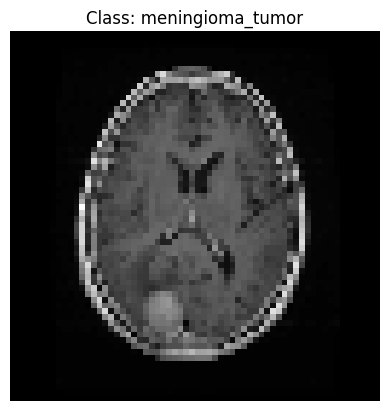

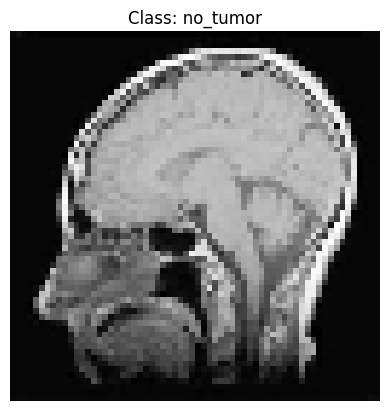

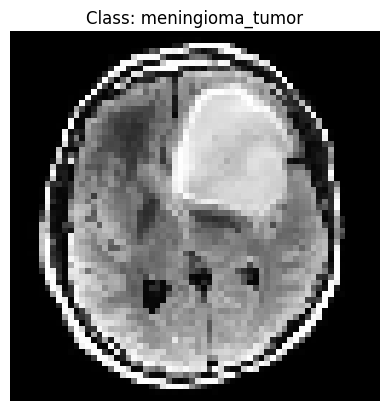

In [12]:
num_images_to_display = 3

for _ in range(num_images_to_display):
  index = np.random.randint(0, len(images) - 1)
  image = images[index]
  label = labels[index]
  class_name = class_names[label]

  plt.figure()
  plt.imshow(image, cmap='gray')
  plt.title(f"Class: {class_name}")
  plt.axis('off')
  plt.show()

## Splitting Train and Test Data
The training and test datasets are split and their shapes displayed. A set seed is used for reproducibility purposes.

In [13]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.15, random_state=42)

print(f"Train: {x_train.shape}")
print(f"Test: {x_test.shape}")

Train: (2774, 64, 64)
Test: (490, 64, 64)


## Normalisation
Only a single colour channel is used (greyscale), so its value just needs to be scaled from 0 - 255 to 0 - 1.

In [14]:
x_train = x_train/255
x_test = x_test/255

## Baseline Model
A simple CNN structure is used to gauge the effectiveness of more complex models.

In [15]:
# Constructing Model
baseline_model = Sequential()

baseline_model.add(Input(shape=(64, 64, 1)))
baseline_model.add(Conv2D(32, (3, 3), activation='relu'))
baseline_model.add(MaxPooling2D((2, 2)))
baseline_model.add(Flatten())
baseline_model.add(Dense(64, activation='relu'))
baseline_model.add(Dense(4, activation='softmax'))

# Training
opt = optimizers.Adam(learning_rate = 0.001)
baseline_model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = (['accuracy']))
hist = baseline_model.fit(x_train, y_train, epochs = 30, batch_size = 32, validation_split = 0.2)

# Calculating Accuracies
y_train_pred = baseline_model.predict(x_train)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)

y_pred = baseline_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

train_accuracy = accuracy_score(y_train, y_train_pred_classes)
test_accuracy = accuracy_score(y_test, y_pred_classes)

print(f"Training Accuracy: {train_accuracy*100:.2f}%")
print(f"Testing Accuracy: {test_accuracy*100:.2f}%")

Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5507 - loss: 1.0355 - val_accuracy: 0.6793 - val_loss: 0.7808
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7467 - loss: 0.6417 - val_accuracy: 0.7495 - val_loss: 0.6217
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8301 - loss: 0.4727 - val_accuracy: 0.7964 - val_loss: 0.5841
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8761 - loss: 0.3544 - val_accuracy: 0.8090 - val_loss: 0.5483
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9216 - loss: 0.2485 - val_accuracy: 0.8144 - val_loss: 0.5059
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9437 - loss: 0.1864 - val_accuracy: 0.7964 - val_loss: 0.5485
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9716 - loss: 0.1235 - val_accuracy: 0.8378 - val_loss: 0.4671
Epoch 8/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9869 - loss: 0.0828 - val_accuracy: 0.8505 - v

## The Final CNN
The CNN model is created using the following architecture:
- An **input** layer of size 64x64x1 (i.e. the image resolution).
- 3x **convolutional/maxpooling** layers using *relu* activation.
- A **flatten** layer used to transition to dense layers.
- A single **dense** layer.
- An **output** layer which produces a result via *softmax* activation.
- Scattered **dropout** layers throughout the model to prevent overfitting.


In [16]:
K.clear_session()

model = Sequential()

model.add(Input(shape=(64, 64, 1)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.35))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 683,140 (2.61 MB)

 Trainable params: 683,140 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

## Model Compilation and Training
The model is optimised using the widely-used Adam optimiser - which depends only the learning rate. This is a multi-class classification problem so categorical crossentropy is used as the loss function. Performance is measured using the accuracy metric. Training is done using min-batches over a number of epochs.

In [17]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=42)

opt = optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = (['accuracy']))
hist = model.fit(x_train, y_train, epochs = 30, batch_size = 64, validation_data = (x_val, y_val))

Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.4268 - loss: 1.2649 - val_accuracy: 0.5441 - val_loss: 1.1509
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.5714 - loss: 1.0413 - val_accuracy: 0.5928 - val_loss: 0.9550
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.6278 - loss: 0.9032 - val_accuracy: 0.6793 - val_loss: 0.7827
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.6827 - loss: 0.7996 - val_accuracy: 0.7297 - val_loss: 0.6811
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.6981 - loss: 0.7175 - val_accuracy: 0.7766 - val_loss: 0.6047
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.7287 - loss: 0.6635 - val_accuracy: 0.7964 - val_loss: 0.6088
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.7544 - loss: 0.6253 - val_accuracy: 0.7784 - val_loss: 0.5544
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.7778 - loss: 0.5629 - val_accuracy: 0.8108 - v

## Model Predictions
Here one instance of a model's predictive capabilities are shown for a randomly selected test data image. The image's predicted and actual classes are both shown.

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Text(0.5, 0, 'Actual -> meningioma_tumor')

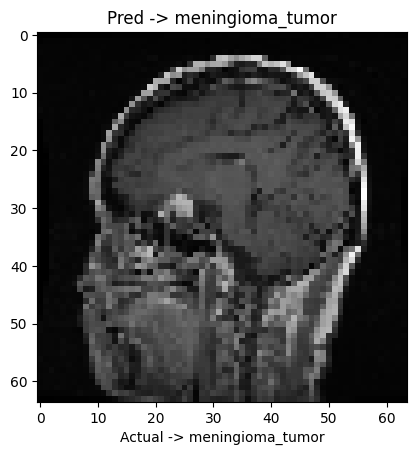

In [18]:
y_hat = model.predict(x_test)

x = np.random.randint(0, len(x_test))
pred_class = np.argmax(y_hat[x])
pred_class = class_names[pred_class]
acu = class_names[y_test[x]]


t = f'Pred -> {pred_class}'
p = f'Actual -> {acu}'

plt.figure()
plt.imshow(x_test[x], cmap="gray")
plt.title(t)
plt.xlabel(p)

## Model Performance
Plotting training and validation accuracies and losses as a function of epoch number to show that the model doesn't overfit.

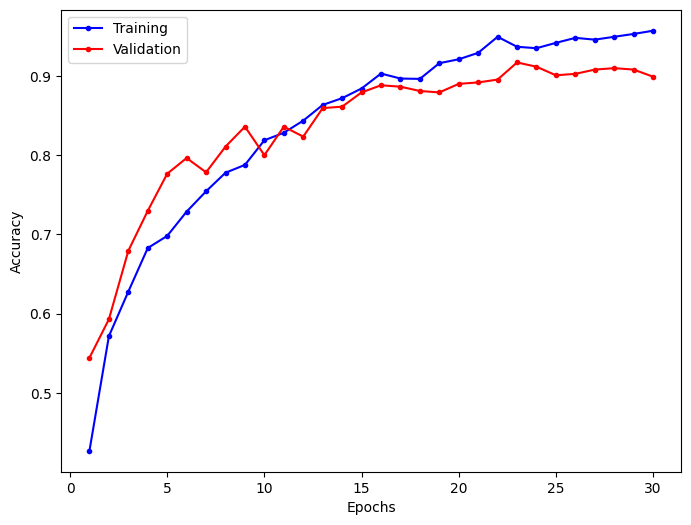

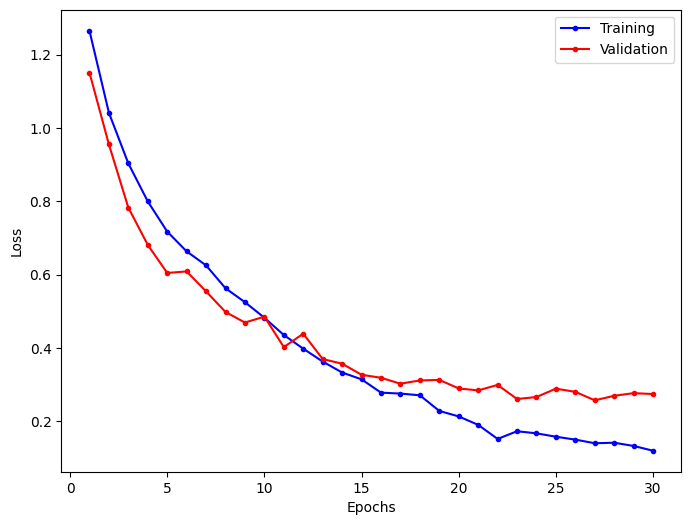

In [19]:
# accuracy
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_acc, 'b.-', label='Training')
plt.plot(epochs, val_acc, 'r.-', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# loss
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, 'b.-', label='Training')
plt.plot(epochs, val_loss, 'r.-', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Here the training and testing accuracies and F1 scores for the CNN model are calculated and displayed.

In [20]:
y_train_pred = model.predict(x_train)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)

y_val_pred = model.predict(x_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Accuracies
train_accuracy = accuracy_score(y_train, y_train_pred_classes)
val_accuracy = accuracy_score(y_val, y_val_pred_classes)
test_accuracy = accuracy_score(y_test, y_pred_classes)

# F1 Scores
train_f1 = f1_score(y_train, y_train_pred_classes, average='weighted')
val_f1 = f1_score(y_val, y_val_pred_classes, average='weighted')
test_f1 = f1_score(y_test, y_pred_classes, average='weighted')

# Outputting results
print("Training")
print(f"\tAccuracy: {train_accuracy*100:.2f}%")
print(f"\tF1 Score: {train_f1:.3f}")

print("\nValidation")
print(f"\tAccuracy: {val_accuracy*100:.2f}%")
print(f"\tF1 Score: {val_f1:.3f}")

print("\nTesting")
print(f"\tAccuracy: {test_accuracy*100:.2f}%")
print(f"\tF1 Score: {test_f1:.3f}")


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Training
	Accuracy: 99.10%
	F1 Score: 0.991

Validation
	Accuracy: 89.91%
	F1 Score: 0.898

Testing
	Accuracy: 89.18%
	F1 Score: 0.892
